In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import path

In [37]:
#download a test image

if not path.exists("inputs/avergra2.bmp"):
    !wget https://users.itk.ppke.hu/~horan/avergra2.bmp -P ./inputs/
if not path.exists("inputs/Diffus.bmp"):
    !wget http://users.itk.ppke.hu/~horan/cnn/hfimgs/Diffus.bmp -P ./inputs/

In [38]:
def Uint8ToCell(arr):
    #this function convertrs an array from unit8, 0-255, oBlack, 255White to -1White, 1Black
    arr=(-1)*((arr.astype(np.float))/127.5-1.0)
    return arr

In [39]:
def CellToUint8(arr):
    #this function converts an array from unit8, 0-255, oBlack, 255White to -1White, 1Black
    arr=((arr*-1)+1.0)*127.5;
    arr=arr.astype(np.uint8)
    return arr

In [40]:
def StandardCNNNonliearity(x):
    #this function implements the standard CNN nonlinearity, all values are saturated below -1 and above 1
    back=x
    back[x<-1]=-1
    back[x>1]=1
    return back

In [41]:
class CellSim():
    def __init__(self):
        self.Input = []
        self.State = []
        self.Output = []
        self.A = np.zeros((3,3))
        self.B = np.zeros((3,3))
        self.Z = 0
        self.SimTime = 1
        self.TimeStep = 0.1
        self.OutputNonlin = StandardCNNNonliearity
        self.Boundary = 'Constant'
        self.BoundValue = 0

    def GetOutput(self):
        return self.Output

    def SetTimeStep(self,Ts):
        #this function sets the A template of the simulator
        #check if it is an N times N matrix - later on these could be functions
        self.TimeStep = Ts

    def SetSimTime(self,T):
        #this function sets the A template of the simulator
        #check if it is an N times N matrix - later on these could be functions
        self.SimTime = T

    def SetInput(self,In):
        #this function sets the A template of the simulator
        #check if it is an N times N matrix - later on these could be functions
        #and convert image to CellNN domain
        img=cv2.imread(In)
        img=Uint8ToCell(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) )
        self.Input = img

    def SetState(self,St):
        #this function sets the A template of the simulator
        #check if it is an N times N matrix - later on these could be functions
        img=cv2.imread(St)
        img=Uint8ToCell(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) )
        self.State = img

    def SetZ(self,z):
        self.SetBias(z)

    def SetBias(self,z):
        self.Z=z

    def SetA(self,a):
        self.SetATemplate(a)

    def SetATemplate(self,a):
        #this function sets the A template of the simulator
        #check if it is an N times N matrix - later on these could be functions
        self.A = a

    def SetB(self,b):
        self.SetBTemplate(b)

    def SetBTemplate(self,b):
        #this function sets the A template of the simulator
        #check if it is an N times N matrix - later on these could be functions
        self.B = b

    def Euler(self,f,y0,StartTime,EndTime,h):
        t,y = StartTime,y0
        Traj=np.zeros( (  int((EndTime-StartTime)/h)+1   ,y0.shape[0]) )
        ind=0
        while t <= EndTime:
            t += h
            y += h * f(t,y)
            Traj[ind,:]=y
            ind+=1
        return y, Traj

    def Simulate(self):
        Ret, Traj=self.Euler(self.cell_equation,self.State.flatten(),0, self.SimTime,0.1)
        SizeX=self.State.shape[0]
        SizeY=self.State.shape[1]
        OutImg=self.OutputNonlin(np.reshape(Ret,[SizeX,SizeY]))

        #r = ode(self.cell_equation).set_integrator('vode', method='bdf', with_jacobian=False)
        #r = ode(self.cell_equation).set_integrator('dopri')
        #r.set_initial_value(self.State.flatten(), 0)
        #start= time.time()
        #while r.successful() and r.t < self.SimTime:
        #   r.integrate(r.t+self.TimeStep)
        #   print(r.t)
        #end= time.time()
        #print(end-start)
        #SizeX=self.State.shape[0]
        #SizeY=self.State.shape[1]
        #OutImg=self.OutputNonlin(np.reshape(r.y,[SizeX,SizeY]))
        return OutImg, Traj

    def cell_equation(self,t,X):
        # ADDING INPUT TO THE SYSTEM -- NOT GENERAL, JUST FOR THE CHAOTIC EXAMPLE
        self.Input[0] = 4.04*np.sin(np.pi*t/2.0)
        self.Input[1] = 0

        #This function impelment the differential equation determining the standard cnn cell:
        #xdot = -x + Ay + Bu + z
        #the parameters of the CNN array (templates) are stored in P
        #reshape the 1xN input for the size of the image -ode solvers can only deal with vectors but code is more understandable if    we use arrays
        SizeX=self.State.shape[0]
        SizeY=self.State.shape[1]
        x=np.reshape(X,[SizeX,SizeY])
        #we will return the derivative in this array
        dx=np.zeros( (SizeX,SizeY))

        #go through all elements of the array
        for a in range(SizeX):
            for b in range(SizeY):
                #if we are at the edge of the array, boundary conditions should be applied
                if (a==0) or (b==0) or (a==(SizeX-1)) or (b==(SizeY-1)):
                    inputregion=np.zeros((3,3))
                    stateregion=np.zeros((3,3))
                    #check the local region around the cell
                    for c in range(-1,2):
                        for d in range(-1,2):
                            #check boundary conditions if we are at the edge of the array
                            if self.Boundary=='Constant':
                                #constant boundary condition, virtual cells have fix values
                                if a+c<0 or b+d<0 or a+c>(SizeX-1) or b+d>(SizeY-1):
                                    inputregion[c+1,d+1]=self.BoundValue
                                    stateregion[c+1,d+1]=self.BoundValue
                                else:
                                    inputregion[c+1,d+1]=self.Input[a+c,b+d]
                                    stateregion[c+1,d+1]=x[a+c,b+d]
                            elif self.Boundary=='ZeroFlux':
                                #zero-flux condition- virtual cells have the value of the closes real cell
                                inda=a+c
                                if a+c<0:
                                    inda=0
                                elif a+c>(SizeX-1):
                                    inda=SizeX-1
                                indb=b+d
                                if b+d<0:
                                    indb=0
                                elif b+d>(SizeY-1):
                                    indb=SizeY-1
                                inputregion[c+1,d+1]=self.Input[inda,indb]
                                stateregion[c+1,d+1]=x[inda,indb]
                            elif self.Boundary=='Periodic':
                                #periodic condition- the value of the next real cell at the other edge of the array will be used
                                inda=a+c
                                if a+c<0:
                                    inda=SizeX-1
                                elif a+c>SizeX-1:
                                    inda=0
                                indb=b+d
                                if b+d<0:
                                    indb=SizeY-1
                                elif b+d>SizeY-1:
                                    indb=0
                                inputregion[c+1,d+1]=self.Input[inda,indb]
                                stateregion[c+1,d+1]=x[inda,indb]

                else:
                    #if we are not at the edge, just select the region, all cells are valid
                    inputregion=self.Input[a-1:a+2,b-1:b+2]
                    stateregion=x[a-1:a+2,b-1:b+2]

                y=self.OutputNonlin(stateregion)
                #calculate the derivative according to the equation
                dx[a,b]=-x[a,b] + np.sum(np.multiply(self.A,y))  + np.sum(np.multiply(self.B,inputregion)) + self.Z
        #reshape back to Nx1
        dx=np.reshape(dx,[SizeX*SizeY])

        return dx

# Szinuszos dinamika

<function matplotlib.pyplot.show(close=None, block=None)>

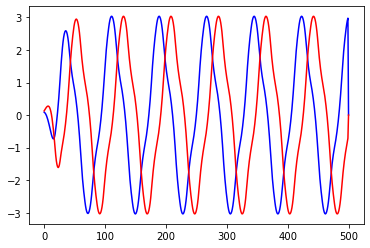

In [42]:
CNN=CellSim() #intialization of the simulator

CNN.SetA([[0.0, 2.0, 0.0],[0.0, 2.0, 0.0],[0.0, -2.0, 0.0]])  
CNN.SetB([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]])
CNN.Z = 0.0 
CNN.State = np.ones((2, 1))*0.1
CNN.Input = np.ones((2, 1))
CNN.Boundary = 'Constant'
CNN.BoundValue = 0.0
CNN.SetSimTime(50.0)
CNN.SetTimeStep(0.1)

OutImg, Traj = CNN.Simulate()

plt.plot(Traj[:, 0], 'b')
plt.plot(Traj[:, 1], 'r')
plt.show

## Fázisportré
Az időt az jelenti ahogy a vonal mentén haladunk végig

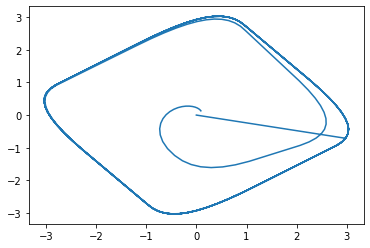

In [43]:
plt.plot(Traj[:,0], Traj[:,1])
plt.show()

# Kaotikus dinamika

<function matplotlib.pyplot.show(close=None, block=None)>

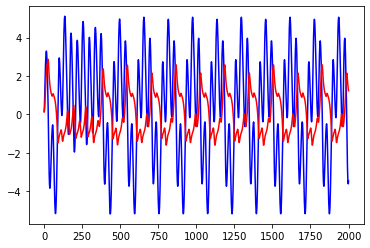

In [44]:
CNN=CellSim() #intialization of the simulator

CNN.SetA([[0.0, 1.2, 0.0],[0.0, 2.0, 0.0],[0.0, -1.2, 0.0]])  
CNN.SetB([[0.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 0.0]])
CNN.Z = 0.0 
CNN.State = np.ones((2, 1))*0.1
CNN.Input = np.ones((2, 1))
CNN.Boundary = 'Constant'
CNN.BoundValue = 0.0
CNN.SetSimTime(200.0)
CNN.SetTimeStep(0.001)

OutImg, Traj = CNN.Simulate()

plt.plot(Traj[:, 0], 'b')
plt.plot(Traj[:, 1], 'r')
plt.show

## Fázisportré

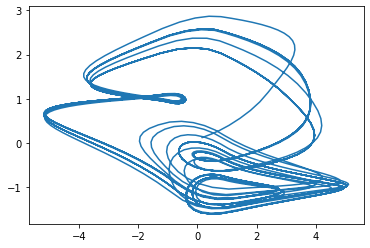

In [45]:
plt.plot(Traj[:,0], Traj[:,1])
plt.show()

# Éldetektor template

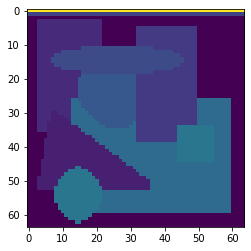

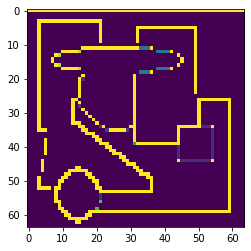

In [46]:
CNN=CellSim() #intialization of the simulator

CNN.SetA([[0.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 0.0]])  
CNN.SetB([[-1.0, -1.0, -1.0],[-1.0, 8.0, -1.0],[-1.0, -1.0, -1.0]])
CNN.Z = -1.0 
CNN.SetState('inputs/avergra2.bmp')
CNN.SetInput('inputs/avergra2.bmp')
CNN.Boundary = 'ZeroFlux'
CNN.SetSimTime(5.0)
CNN.SetTimeStep(0.1)

OutImg, Traj = CNN.Simulate()

plt.imshow(CNN.Input)
plt.figure()
plt.imshow(OutImg)

## Ljapunov fv számolás

In [47]:
def sumIntegrateInverseNonlinearity(y, theta=-1.0):
    summa = 0.0
    BotTriangle = (theta**2)/2.0
    
    for a in range(y.shape[0]):
        if y[a] < 0:
            summa -= BotTriangle-(y[a]**2/2.0)
        else:
            summa -= BotTriangle+(y[a]**2/2.0)
    return summa

In [48]:
# print(Traj.shape)
numElements = CNN.Input.shape[0]*CNN.Input.shape[1]
bias = np.ones(numElements)*CNN.Z
u_hat = np.reshape(CNN.Input, [numElements])
A_hat = np.zeros((numElements, numElements))
B_hat = np.zeros((numElements, numElements))

for a in range(numElements):
    for k in range(-1,2):
        for l in range(-1,2):
            if -1 < a+l+k*CNN.Input.shape[0] < numElements:
                A_hat[a, a+l+k*CNN.Input.shape[0]]= CNN.A[1+l][1+k]
                B_hat[a, a+l+k*CNN.Input.shape[0]]= CNN.B[1+l][1+k]

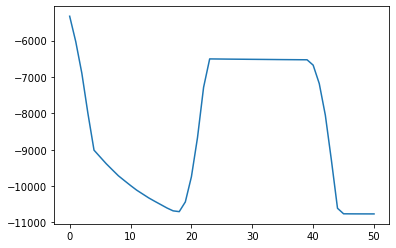

In [49]:
V = np.zeros(Traj.shape[0])
for t in range(Traj.shape[0]):
    x = Traj[t, :]
    y = StandardCNNNonliearity(x)
    part1 = -0.5*np.matmul(np.matmul(y, A_hat), np.transpose(y))
    part2 = sumIntegrateInverseNonlinearity(y)
    part3 = -1*np.matmul(y, np.matmul(B_hat, u_hat))
    part4 = -1*np.matmul(y, bias)
    V[t] = part1 + part2 + part3 + part4
    
plt.plot(V)
plt.show()